In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
!unzip "/content/Classes.zip"

Archive:  /content/Classes.zip
  inflating: Classes/CLEANED_OPEN/Image-OPEN-57-60.jpg  
  inflating: Classes/CLEANED_OPEN/Image-OPEN-35-60.jpg  
  inflating: Classes/CLEANED_OPEN/Image-OPEN-47-55.jpg  
  inflating: Classes/CLEANED_OPEN/Image-OPEN-57-55.jpg  
  inflating: Classes/CLEANED_OPEN/Image-OPEN-51-60.jpg  
  inflating: Classes/CLEANED_OPEN/Image-OPEN-27-60.jpg  
  inflating: Classes/CLEANED_OPEN/Image-OPEN-19-55.jpg  
  inflating: Classes/CLEANED_OPEN/Image-OPEN-5-55.jpg  
  inflating: Classes/CLEANED_OPEN/Image-OPEN-34-60.jpg  
  inflating: Classes/CLEANED_OPEN/Image-OPEN-1-55.jpg  
  inflating: Classes/CLEANED_OPEN/Image-OPEN-67-60.jpg  
  inflating: Classes/CLEANED_OPEN/Image-OPEN-27-55.jpg  
  inflating: Classes/CLEANED_OPEN/Image-OPEN-33-55.jpg  
  inflating: Classes/CLEANED_OPEN/Image-OPEN-59-55.jpg  
  inflating: Classes/CLEANED_OPEN/Image-OPEN-36-60.jpg  
  inflating: Classes/CLEANED_OPEN/Image-OPEN-68-60.jpg  
  inflating: Classes/CLEANED_OPEN/Image-OPEN-44-60.jpg  
  

In [5]:
from sklearn.datasets import load_files 
from keras.utils import np_utils

from keras.preprocessing import image
from tqdm import tqdm # progress bar

data_dir = "/content/Classes"
batch_size = 32;
img_height = 299; 
img_width = 299;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.1,
    subset = "training",
    seed = 49,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.1,
    subset = "validation",
    seed = 49,
    image_size = (img_height, img_width),
    batch_size = batch_size
)        

        


Found 3761 files belonging to 4 classes.
Using 3385 files for training.
Found 3761 files belonging to 4 classes.
Using 376 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['CLEANED_OPEN', 'Colonial Streetlights', 'Enclosed Streetlights', 'Non-Streetlights']


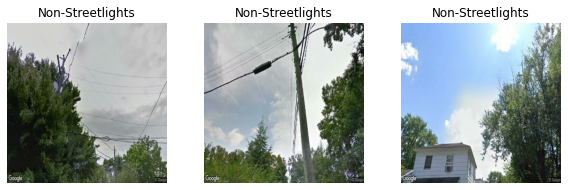

In [7]:
#View 3 images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
## State Variables 
n_classes=4
dataset_size=3671

In [9]:
# Standardize data
from tensorflow.keras import layers
normalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
validation_ds = validation_ds.map(lambda x, y: (normalization_layer(x), y))

In [10]:
# Cache to RAM (optional) - speed up google drive
from tensorflow import data
AUTOTUNE = data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
def preprocess(image, label):
    image = tf.keras.applications.inception_resnet_v2.preprocess_input(image)
    return image, label

In [12]:
def data_augmentation(image, label):
    image = tf.image.random_flip_left_right(image) 
    return image, label

In [13]:
train_ds = train_ds.shuffle(1000).repeat(50) 
train_ds = train_ds.map(data_augmentation)
train_set = train_ds.map(preprocess).prefetch(1)
valid_set = validation_ds.map(preprocess).prefetch(1)

In [14]:
train_set

<PrefetchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.int32)>

In [15]:
valid_set

<PrefetchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.int32)>

In [16]:
base_model2 = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet")
base_model2.trainable = False
avg2 = keras.layers.GlobalAveragePooling2D()(base_model2.output)
output2 = keras.layers.Dense(n_classes, activation="softmax")(avg2)
model2 = keras.models.Model(inputs=base_model2.input, outputs=output2)

94773248/94765736 [==============================] - 1s 0us/step


In [18]:
from keras.optimizers import SGD
model2.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history2 = model2.fit(train_ds, epochs=15, validation_data=validation_ds)

Epoch 1/15
5300/5300 [==============================] - 756s 142ms/step - loss: 0.7238 - accuracy: 0.6850 - val_loss: 0.7456 - val_accuracy: 0.6782
Epoch 2/15
5300/5300 [==============================] - 751s 142ms/step - loss: 0.6901 - accuracy: 0.7038 - val_loss: 0.7252 - val_accuracy: 0.6782
Epoch 3/15
5300/5300 [==============================] - 750s 141ms/step - loss: 0.6687 - accuracy: 0.7147 - val_loss: 0.7134 - val_accuracy: 0.7021
Epoch 4/15
5300/5300 [==============================] - 750s 142ms/step - loss: 0.6514 - accuracy: 0.7225 - val_loss: 0.7151 - val_accuracy: 0.6888
Epoch 5/15
5300/5300 [==============================] - 748s 141ms/step - loss: 0.6409 - accuracy: 0.7279 - val_loss: 0.7118 - val_accuracy: 0.7074
Epoch 6/15
5300/5300 [==============================] - 748s 141ms/step - loss: 0.6314 - accuracy: 0.7308 - val_loss: 0.7241 - val_accuracy: 0.6729
Epoch 7/15
5300/5300 [==============================] - 752s 142ms/step - loss: 0.6228 - accuracy: 0.7344 - val_

In [19]:
base_model2.trainable = True

model2.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history2 = model2.fit(train_ds, epochs=15, validation_data=validation_ds)

Epoch 1/15
5300/5300 [==============================] - 1828s 344ms/step - loss: 8.4593 - accuracy: 0.9260 - val_loss: 16.5692 - val_accuracy: 0.8085
Epoch 2/15
5300/5300 [==============================] - 1818s 343ms/step - loss: 0.0626 - accuracy: 0.9957 - val_loss: 16.1788 - val_accuracy: 0.8378
Epoch 3/15
5300/5300 [==============================] - 1818s 343ms/step - loss: 0.0341 - accuracy: 0.9978 - val_loss: 15.2343 - val_accuracy: 0.8404
Epoch 4/15
5300/5300 [==============================] - 1815s 342ms/step - loss: 0.0384 - accuracy: 0.9982 - val_loss: 14.5706 - val_accuracy: 0.8511
Epoch 5/15
5300/5300 [==============================] - 1818s 343ms/step - loss: 0.0226 - accuracy: 0.9988 - val_loss: 11.6494 - val_accuracy: 0.8644
Epoch 6/15
5300/5300 [==============================] - 1819s 343ms/step - loss: 0.0226 - accuracy: 0.9989 - val_loss: 14.8707 - val_accuracy: 0.8484
Epoch 7/15
5300/5300 [==============================] - 1820s 343ms/step - loss: 0.0218 - accuracy: 